In [390]:
# General setup
import pandas as pd
import numpy as np
import re

# Modeling tools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Preprocessing and scoring
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import log_loss, roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Visualization
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image  
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline

# EDA and clean up with scrape of 2015-2019 Data
***

In [308]:
bgg = pd.read_csv('../data/bgg_complete_1419.csv', index_col=0)

In [309]:
bgg.head()

,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
0,NaN,246783,Wildlands: The Unquiet Dead,14,60,2,4,[],"['Expansion for Base-game', 'Miniatures']",2.0,2018,5.653,7.44,108.0
1,12558.0,205776,Gentleman's Deal,12,60,5,9,"['Partnerships', 'Voting']","['Bluffing', 'Negotiation', 'Party Game']",1.0,2016,5.514,6.21,47.0
2,13663.0,188129,Heroes and Tricks,8,25,2,6,"['Hand Management', 'Trick-taking']","['Deduction', 'Fantasy']",0.0,2017,5.504,5.67,83.0
3,13323.0,206083,Ragers: Champions of the Arena,14,20,2,2,"['Rock-Paper-Scissors', 'Simultaneous Action S...","['Card Game', 'Fantasy', 'Fighting']",1.0,2016,5.507,5.98,36.0
4,6390.0,201006,Bumúntú,8,30,2,5,['Action / Movement Programming'],"['Animals', 'Educational']",2.0,2019,5.603,7.15,95.0


In [310]:
# Drop rows with no rank, as they are expansions to games, and not individual games
to_drop = bgg[bgg['rank'].isna()]
bgg.drop(to_drop.index, axis=0, inplace=True)
len(bgg)

3142

In [311]:
# Filling in median value for rows with 0 weight given
bgg.loc[bgg["weight"] == 0] = bgg['weight'].median()

In [312]:
# Double checking that it pulled only those for the correct year
len(bgg[bgg['year'] < 2015]), len(bgg)

(156, 3142)

In [313]:
# Dropping rows with dates prior to 2015 (bad API pull)
to_drop = bgg[bgg['year'] < 2015]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [314]:
len(bgg)

2986

In [315]:
bgg.describe()

,rank,id,age,avg_time,min_players,max_players,weight,year,geek,avg,num_rev
count,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000
mean,5627.139652,199141.554588,10.568989,125.158741,1.877763,5.687207,2.185205,2016.504689,5.844739,6.967579,844.825184
std,3892.970305,34978.264744,3.419438,2210.236276,0.693686,20.202906,0.777614,1.194408,0.459034,0.757621,2586.059547
min,1.000000,16271.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2015.000000,4.779000,2.440000,30.000000
25%,2452.500000,176533.500000,8.000000,30.000000,1.000000,4.000000,1.600000,2015.000000,5.565000,6.510000,92.000000
50%,5066.500000,197185.000000,12.000000,50.000000,2.000000,4.000000,2.062500,2016.000000,5.653000,6.960000,190.000000
75%,7925.500000,225122.250000,13.000000,90.000000,2.000000,5.000000,2.708300,2017.000000,5.940000,7.430000,539.500000
max,17135.000000,272409.000000,21.000000,120000.000000,8.000000,999.000000,5.000000,2019.000000,8.610000,9.600000,51149.000000


In [316]:
len(bgg[bgg['num_rev'] < 50])

255

In [317]:
# Removing rows with less than 50 reviews
to_drop = bgg[bgg['num_rev'] < 50]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [318]:
bgg.head()

,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
4,6390.0,201006.0,Bumúntú,8.0,30.0,2.0,5.0,['Action / Movement Programming'],"['Animals', 'Educational']",2.0000,2019.0,5.603,7.15,95.0
7,3426.0,256839.0,VektoRace,12.0,120.0,2.0,4.0,"['Action / Movement Programming', 'Simulation']","['Racing', 'Sports']",2.3333,2018.0,5.785,8.32,196.0
8,6801.0,258104.0,Tribes: Dawn of Humanity,10.0,45.0,2.0,4.0,"['Grid Movement', 'Tile Placement']","['Ancient', 'Civilization', 'Exploration', 'Pr...",2.4000,2018.0,5.590,6.80,99.0
11,5451.0,241796.0,Nut So Fast,8.0,20.0,3.0,6.0,['Pattern Recognition'],"['Action / Dexterity', 'Party Game']",1.0000,2018.0,5.636,7.03,157.0
14,9524.0,233206.0,Werebeasts,8.0,15.0,3.0,10.0,['Set Collection'],"['Deduction', 'Party Game']",1.5000,2018.0,5.543,6.30,94.0


In [319]:
bgg['mechanic'] = bgg['mechanic'].apply(lambda x: re.sub("\[|\]|'","", x).replace(" ",""))
bgg['category'] = bgg['category'].apply(lambda x: re.sub("\[|\]|'","", x).replace(" ",""))

In [320]:
bgg = bgg.reset_index()
bgg.head()

,index,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
0,4,6390.0,201006.0,Bumúntú,8.0,30.0,2.0,5.0,Action/MovementProgramming,"Animals,Educational",2.0000,2019.0,5.603,7.15,95.0
1,7,3426.0,256839.0,VektoRace,12.0,120.0,2.0,4.0,"Action/MovementProgramming,Simulation","Racing,Sports",2.3333,2018.0,5.785,8.32,196.0
2,8,6801.0,258104.0,Tribes: Dawn of Humanity,10.0,45.0,2.0,4.0,"GridMovement,TilePlacement","Ancient,Civilization,Exploration,Prehistoric,T...",2.4000,2018.0,5.590,6.80,99.0
3,11,5451.0,241796.0,Nut So Fast,8.0,20.0,3.0,6.0,PatternRecognition,"Action/Dexterity,PartyGame",1.0000,2018.0,5.636,7.03,157.0
4,14,9524.0,233206.0,Werebeasts,8.0,15.0,3.0,10.0,SetCollection,"Deduction,PartyGame",1.5000,2018.0,5.543,6.30,94.0


In [321]:
mechanics_df = pd.DataFrame(bgg['mechanic'].str.split(',').tolist(), index=bgg.index).stack()
mechanics_df = mechanics_df.reset_index()
mechanics_df = mechanics_df.drop('level_1', axis=1)
mechanics_df.columns = ['id', 'mechanics']

In [322]:
mechanics_df.head()

,id,mechanics
0,0,Action/MovementProgramming
1,1,Action/MovementProgramming
2,1,Simulation
3,2,GridMovement
4,2,TilePlacement


In [325]:
encoder = OneHotEncoder(categories="auto").fit(mechanics_df[["mechanics"]])

In [378]:
mech_ohe = pd.DataFrame(encoder.transform(mechanics_df[["mechanics"]]).toarray(),
                   columns=encoder.get_feature_names(["mech"]))

mech_ohe_df = pd.concat([mechanics_df.drop("mechanics", axis=1), mech_ohe], axis=1)

mech_dedup = mech_ohe_df.groupby("id")[mech_ohe.columns].agg("sum").reset_index()

mech_dedup.head()

,id,mech_,mech_Acting,mech_Action/MovementProgramming,mech_ActionPointAllowanceSystem,mech_Area-Impulse,mech_AreaControl/AreaInfluence,mech_AreaEnclosure,mech_AreaMovement,mech_Auction/Bidding,...,mech_Storytelling,mech_TakeThat,mech_TilePlacement,mech_TimeTrack,mech_Trading,mech_Trick-taking,mech_VariablePhaseOrder,mech_VariablePlayerPowers,mech_Voting,mech_WorkerPlacement
0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [323]:
cat_df = pd.DataFrame(bgg['category'].str.split(',').tolist(), index=bgg.index).stack()
cat_df = cat_df.reset_index()
cat_df = cat_df.drop('level_1', axis=1)
cat_df.columns = ['id', 'category']

In [374]:
cat_df.head()

,id,category
0,0,Animals
1,0,Educational
2,1,Racing
3,1,Sports
4,2,Ancient


In [328]:
encoder_2 = OneHotEncoder(categories="auto").fit(cat_df[["category"]])

In [379]:
cat_ohe = pd.DataFrame(encoder_2.transform(cat_df[["category"]]).toarray(),
                   columns=encoder_2.get_feature_names(["cat"]))

cat_ohe_df = pd.concat([cat_df.drop("category", axis=1), cat_ohe], axis=1)

cat_dedup = cat_ohe_df.groupby("id")[cat_ohe.columns].agg("sum").reset_index()

cat_dedup.head()

,id,cat_,"cat_""ChildrensGame""",cat_AbstractStrategy,cat_Action/Dexterity,cat_Adventure,cat_AgeofReason,cat_AmericanCivilWar,cat_AmericanIndianWars,cat_AmericanRevolutionaryWar,...,cat_Transportation,cat_Travel,cat_Trivia,cat_VideoGameTheme,cat_VietnamWar,cat_Wargame,cat_WordGame,cat_WorldWarI,cat_WorldWarII,cat_Zombies
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [380]:
bgg_complete = pd.concat([bgg, mech_dedup, cat_dedup], axis=1)
bgg_complete = bgg_complete.drop(['mechanic','category'], axis=1)
bgg_complete.shape

(2731, 153)

In [381]:
bgg_complete['geek'].describe()

count    2731.000000
mean        5.873798
std         0.469515
min         4.779000
25%         5.582000
50%         5.676000
75%         5.989000
max         8.610000
Name: geek, dtype: float64

In [382]:
bgg_complete['top_score'] = bgg['geek'].apply(lambda x: 1 if x > 5.989000 else 0)

In [383]:
bgg_complete.columns[:20]

Index(['index', 'rank', 'id', 'name', 'age', 'avg_time', 'min_players',
       'max_players', 'weight', 'year', 'geek', 'avg', 'num_rev', 'id',
       'mech_', 'mech_Acting', 'mech_Action/MovementProgramming',
       'mech_ActionPointAllowanceSystem', 'mech_Area-Impulse',
       'mech_AreaControl/AreaInfluence'],
      dtype='object')

In [393]:
drop = ['index','rank', 'id', 'name', 'year', 'geek', 'avg_time',
        'age', 'avg', 'num_rev', 'mech_', 'cat_', 'top_score']

# drop = ['rank', 'game_id', 'names', 'geek_rating', 'age',
#               'avg_time', 'top_score', 'category','mechanic', 'weight']

to_drop = drop

In [394]:
X = bgg_complete.drop(to_drop, axis=1)
y = bgg_complete['top_score']

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

*** 

# Initial EDA with complete data set
***

In [2]:
df = pd.read_csv('data/bgg_db_2018_01.csv', encoding='iso-8859-1')

In [3]:
df.head()

,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.01310,8.52234,9841,https://cf.geekdo-images.com/images/pic2437871...,12,"Action / Movement Programming, Co-operative Pl...",18217,"Adventure, Exploration, Fantasy, Fighting, Min...",Isaac Childres,3.7720
1,2,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66575,8.49837,23489,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",38105,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8056
2,3,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.65702,8.32401,10679,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",14147,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3538
3,4,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,120,180,2005,8.35188,8.21012,29923,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",41094,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5446
4,5,https://boardgamegeek.com/boardgame/167791/ter...,167791,Terraforming Mars,1,5,120,120,120,2016,8.38331,8.17328,20468,https://cf.geekdo-images.com/images/pic3536616...,12,"Card Drafting, Hand Management, Tile Placement...",26145,"Economic, Environmental, Industry / Manufactur...",Jacob Fryxelius,3.2465


In [4]:
df['mechanic'] = df['mechanic'].apply(lambda x: [m for m in x.split(", ")])
df['category'] = df['category'].apply(lambda x: [c for c in x.split(", ")])

In [5]:
mechanics = df['mechanic'].tolist()
categories = df['category'].tolist()

In [6]:
mechanic_cols = sorted(set([val for sublist in mechanics for val in sublist]))
category_cols = sorted(set([val for sublist in categories for val in sublist]))
len(mechanic_cols), len(category_cols)

(52, 84)

In [199]:
# mech_cols = []
# for col in mechanic_cols:
#     disp_name = col.lower().replace("/","").replace(" ","_")
#     mech_cols.append('mech_' + disp_name)
#     df['mech_' + disp_name] = 0
#     col_names.append('mech_' + disp_name)

In [99]:
cat_cols = []
for col in category_cols:
    disp_name = col.lower().replace("/","").replace(" ","_")
    cat_cols.append('cat_' + disp_name)
#     df['cat_' + disp_name] = 0
#     col_names.append('cat_' + disp_name)

In [197]:
# mech_cols = []
# for mech in mechanic_cols:
#     disp_name = mech.lower().replace("/","").replace(" ","_")
#     for idx, row in df.iterrows():
#         if mech in row['mechanic']:
#             df['mech_' + disp_name][idx] = 1

In [200]:
# for cat in category_cols:
#     disp_name = cat.lower().replace("/","").replace(" ","_")
#     for idx, row in df.iterrows():
#         if cat in row['category']:
#             df['cat_' + disp_name][idx] = 1

In [47]:
df.drop(['bgg_url', 'year', 'avg_rating',
       'num_votes', 'image_url', 'owned', 'designer'], axis=1, inplace=True)

In [55]:
df.to_csv('data/bgg_binned_2018.csv')

### Prepping for testing

In [7]:
bgg = pd.read_csv('data/bgg_binned_2018.csv', index_col=0)

In [8]:
bgg.columns

Index(['rank', 'game_id', 'names', 'min_players', 'max_players', 'avg_time',
       'min_time', 'max_time', 'geek_rating', 'age',
       ...
       'cat_travel', 'cat_trivia', 'cat_video_game_theme', 'cat_vietnam_war',
       'cat_wargame', 'cat_word_game', 'cat_world_war_i', 'cat_world_war_ii',
       'cat_zombies', 'cat_none'],
      dtype='object', length=149)

In [9]:
bgg['geek_rating'].describe()

count    4999.000000
mean        6.082797
std         0.482280
min         5.636190
25%         5.720640
50%         5.901470
75%         6.289785
max         8.522340
Name: geek_rating, dtype: float64

In [10]:
bgg['top_score'] = bgg['geek_rating'].apply(lambda x: 1 if x > 6.289785 else 0)

In [11]:
bgg.head()

,rank,game_id,names,min_players,max_players,avg_time,min_time,max_time,geek_rating,age,...,cat_trivia,cat_video_game_theme,cat_vietnam_war,cat_wargame,cat_word_game,cat_world_war_i,cat_world_war_ii,cat_zombies,cat_none,top_score
0,1,174430,Gloomhaven,1,4,150,90,150,8.52234,12,...,0,0,0,0,0,0,0,0,0,1
1,2,161936,Pandemic Legacy: Season 1,2,4,60,60,60,8.49837,13,...,0,0,0,0,0,0,0,0,0,1
2,3,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,8.32401,14,...,0,0,0,0,0,0,0,0,0,1
3,4,12333,Twilight Struggle,2,2,180,120,180,8.21012,13,...,0,0,0,1,0,0,0,0,0,1
4,5,167791,Terraforming Mars,1,5,120,120,120,8.17328,12,...,0,0,0,0,0,0,0,0,0,1


In [12]:
drop = ['rank', 'game_id', 'names', 'geek_rating', 'age',
              'avg_time', 'top_score', 'category','mechanic']

# drop = ['rank', 'game_id', 'names', 'geek_rating', 'age',
#               'avg_time', 'top_score', 'category','mechanic', 'weight']

to_drop = drop

In [13]:
X = bgg.drop(to_drop, axis=1)
y = bgg['top_score']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Decision Tree

In [397]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred_t = clf.predict_proba(X_test)

In [398]:
for i, val in enumerate(clf.feature_importances_):
    if val == (clf.feature_importances_).max():
        print(str(i) + ": " + str(val))

2: 0.276739602624419


In [399]:
# # Summary stats
# print(f"Testing Accuracy for Decision Tree Classifier: {accuracy_score(y_test, y_pred_t) * 100}%")
# print(f"Testing Average Precision Score: {round(average_precision_score(y_test, y_pred_t) * 100, 2)}%")
# print(classification_report(y_test, y_pred))

Log loss: 10.013720165992495

ROC AUC Score: 0.6242544731610338


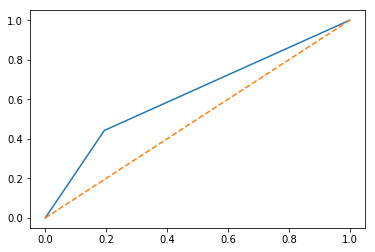

In [400]:
print(f"Log loss: {log_loss(y_test, y_pred_t)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_t[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t[:,1])
#Plot
plt.plot(fpr, tpr)
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');

In [1]:
# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### Decision Tree #2, after Graph Search

In [42]:
clf_2 = DecisionTreeClassifier()

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_split": [1.0, 5, 10, 20]
}

gs_tree = GridSearchCV(clf_2, param_grid, cv=3)

gs_tree.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10], 'min_samples_split': [1.0, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
gs_tree.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}

In [44]:
best = gs_tree.best_params_

clf_2 = DecisionTreeClassifier(**best)
clf_2.fit(X_train, y_train)
y_pred_t2 = clf_2.predict_proba(X_test)

Log loss: 0.669049062919435

ROC AUC Score: 0.71574938782953


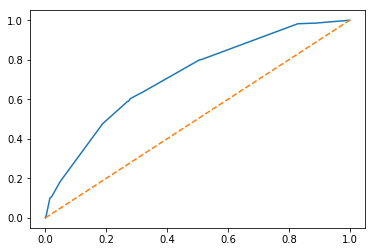

In [46]:
print(f"Log loss: {log_loss(y_test, y_pred_t2)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_t2[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t2[:,1])
#Plot
plt.plot(fpr, tpr)
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');

In [ ]:
# print("Testing Accuracy for Grid Search Best Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_pred_t2) * 100))
# print(f"Testing Average Precision Score: {round(average_precision_score(y_test, y_pred_t2) * 100, 2)}%")
# print(classification_report(y_test, y_pred_t2))

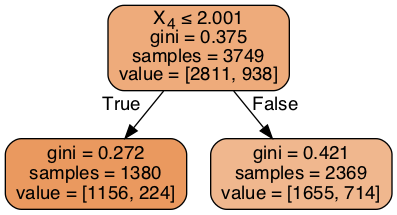

In [314]:
dot_data = StringIO()
export_graphviz(clf_2, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [164]:
# for i, x in enumerate(X.columns):
#     print(str(i) + ": " + x)

### Random Forest Classifier

In [401]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)

forest.fit(X_train, y_train)

y_pred_forest = forest.predict_proba(X_test)
y_pred_f = forest.predict(X_test)

Log loss: 0.5276446583148623

ROC AUC Score: 0.7522255356748397


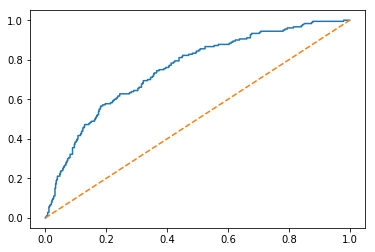

In [402]:
print(f"Log loss: {log_loss(y_test, y_pred_forest)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_forest[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_forest[:,1])
#Plot
plt.plot(fpr, tpr)
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');

In [62]:
# print("Testing Accuracy for Random Forrest Classifier: {:.4}%".format(accuracy_score(y_test, y_pred_forest) * 100))
# print(f"Testing Average Precision Score: {round(average_precision_score(y_test, y_pred_forest) * 100, 2)}%")
# print(classification_report(y_test, y_pred_forest))

### Gradient Boosting Classifier

In [37]:
boost = GradientBoostingClassifier(learning_rate=.01)

boost.fit(X_train, y_train)

boost_pred = boost.predict_proba(X_test)

Log loss: 0.5359928172784619

ROC AUC Score: 0.7390411717203292


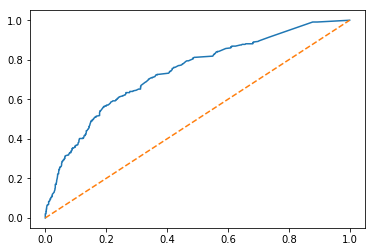

In [38]:
print(f"Log loss: {log_loss(y_test, boost_pred)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, boost_pred[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, boost_pred[:,1])
#Plot
plt.plot(fpr, tpr)
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');

In [ ]:
# print("Testing Accuracy for Gradient Boosting Classifier: {:.4}%".format(accuracy_score(y_test, boost_pred) * 100))
# print(f"Testing Average Precision Score: {round(average_precision_score(y_test, boost_pred) * 100, 2)}%")
# print(classification_report(y_test, boost_pred))

### XG Boost Classifier

In [ ]:
x_boost = xgb.XGBClassifier(learning_rate=.1)

x_boost.fit(X_train, y_train)

In [ ]:
x_pred = x_boost.predict_proba(X_test)

In [ ]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, x_pred) * 100))

print(classification_report(y_test, x_pred))